In [1]:
!cat /usr/local/cuda/version.txt

CUDA Version 10.0.130


In [2]:
# !pip install --upgrade torch

In [3]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1.1)


In [4]:
!pip install dgl-cu100
# !pip install dgl
!pip install torchtext==0.3.1
# !pip install torchtext==0.5.0
!pip install seaborn

## 1. import package

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import dgl.function as fn
import dgl.nn.pytorch.conv as conv
import dgl.nn.pytorch.glob as glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import os

from torchtext import data
from sklearn.preprocessing import LabelEncoder
from torch.nn import init
from dgl.nn.pytorch.softmax import edge_softmax

os.environ['DGLBACKEND'] = 'pytorch'

Using backend: pytorch


## 2. dataset path

In [6]:
path = '/storage/slu/atis/'
# path = '/storage/slu/snips/'
train_path = path + 'train.csv'
dev_path = path + 'dev.csv'
test_path = path + 'test.csv'

## 3. take a look at the train data

In [7]:
train_df = pd.read_csv(train_path)
train_df.head()

,text,slot,intent
0,i want to fly from baltimore to dallas round trip,O O O O O B-fromloc.city_name O B-toloc.city_n...,atis_flight
1,round trip fares from baltimore to philadelphi...,B-round_trip I-round_trip O O B-fromloc.city_n...,atis_airfare
2,show me the flights arriving on baltimore on j...,O O O O O O B-toloc.city_name O B-arrive_date....,atis_flight
3,what are the flights which depart from san fra...,O O O O O O O B-fromloc.city_name I-fromloc.ci...,atis_flight
4,which airlines fly from boston to washington d...,O O O O B-fromloc.city_name O B-toloc.city_nam...,atis_airline


## 4. is cuda available?

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); device

device(type='cuda')

In [9]:
random_state = 2020
# Fix the random seed of package random.
random.seed(random_state)
np.random.seed(random_state)

# Fix the random seed of Pytorch when using CPU.
torch.manual_seed(random_state)
torch.random.manual_seed(random_state)

dgl.random.seed(random_state)

# Fix the random seed of Pytorch when using GPU.
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    torch.cuda.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)

True


## 5. preprocessing data using torchtext

In [10]:
window_size = 4
def text_edge_tokenize(x):
    x = x.split()
    res = []
    for i in range(len(x)):
        for j in range(max(0, i-window_size), min(i+window_size+1, len(x))):
#             if i != j:
            res.append(str(x[i] + ' ' + str(x[j])))
    return res
sentence = 'here we are me'
text_edge_tokenize(sentence)

['here here',
 'here we',
 'here are',
 'here me',
 'we here',
 'we we',
 'we are',
 'we me',
 'are here',
 'are we',
 'are are',
 'are me',
 'me here',
 'me we',
 'me are',
 'me me']

In [11]:
window_size = 11
def text_edge_tokenize(x):
    src = [0, len(x)-1]
    dst = [len(x)-1, 0]
    for i in range(len(x)):
        for j in range(max(0, i-window_size), min(i+window_size+1, len(x))):
#             if i != j:
            src.append(i)
            dst.append(j)
    return src, dst
sentence = np.arange(5)
print(sentence)
src, dst = text_edge_tokenize(sentence)
print(src)
print(dst)

[0 1 2 3 4]
[0, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]
[4, 0, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]


In [12]:
TEXT = data.Field(batch_first=True, lower=True, include_lengths=True)
SLOT_LABEL = data.Field(batch_first=True, is_target=True, include_lengths=True, pad_token=None, unk_token=None)
# SLOT_LABEL = data.Field(batch_first=True, is_target=True, include_lengths=True)
INTENT_LABEL = data.Field(batch_first=True, is_target=True, pad_token=None, unk_token=None)
# INTENT_LABEL = data.Field(batch_first=True, is_target=True, pad_token=None)

In [13]:
fields = [('text', TEXT), ('slot', SLOT_LABEL), ('intent', INTENT_LABEL)]
# fields = {
#     'text': ('text1', TEXT),
#     'edge': ('edge1', TEXT_EDGE),
#     'slot': ('slot1', SLOT_LABEL),
#     'intent': ('intent1', INTENT_LABEL)
# }

In [14]:
train, val, test = data.TabularDataset.splits(
    path=path,
    format='csv',
    train=train_path,
    validation=dev_path,
    test=test_path,
    skip_header=True,
    fields=fields
)

In [15]:
# TEXT.build_vocab(train, vectors='glove.6B.300d')
TEXT.build_vocab(train)
SLOT_LABEL.build_vocab(train)
INTENT_LABEL.build_vocab(train)

In [16]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test),
    batch_sizes=(64, 64, 64), # ATIS=>64,SNIPS=>16
    device=device,
    shuffle=True,
    sort_key= lambda x: len(x.text),
    sort_within_batch=True,
    repeat=False,
)

In [17]:
len(TEXT.vocab), len(TEXT.vocab.stoi), len(SLOT_LABEL.vocab.stoi), len(INTENT_LABEL.vocab.stoi), len(train_iter.dataset)

(869, 869, 120, 21, 4478)

In [18]:
TEXT.vocab.stoi['<tag>'], TEXT.vocab.itos[1], SLOT_LABEL.vocab.stoi['O'], SLOT_LABEL.vocab.itos, SLOT_LABEL.vocab.freqs

(0,
 '<pad>',
 0,
 ['O',
  'B-toloc.city_name',
  'B-fromloc.city_name',
  'I-toloc.city_name',
  'B-depart_date.day_name',
  'B-airline_name',
  'I-fromloc.city_name',
  'B-depart_time.period_of_day',
  'I-airline_name',
  'B-depart_date.day_number',
  'B-depart_date.month_name',
  'B-depart_time.time',
  'B-round_trip',
  'I-round_trip',
  'B-cost_relative',
  'B-flight_mod',
  'B-depart_time.time_relative',
  'I-depart_time.time',
  'B-stoploc.city_name',
  'B-city_name',
  'B-class_type',
  'B-arrive_time.time',
  'B-arrive_time.time_relative',
  'I-class_type',
  'I-arrive_time.time',
  'B-flight_stop',
  'B-airline_code',
  'I-depart_date.day_number',
  'I-fromloc.airport_name',
  'B-arrive_date.day_name',
  'B-flight_number',
  'B-depart_date.date_relative',
  'B-toloc.state_code',
  'B-depart_date.today_relative',
  'B-fromloc.airport_name',
  'B-toloc.state_name',
  'B-fare_basis_code',
  'B-flight_time',
  'B-or',
  'B-arrive_time.period_of_day',
  'I-airport_name',
  'B-meal

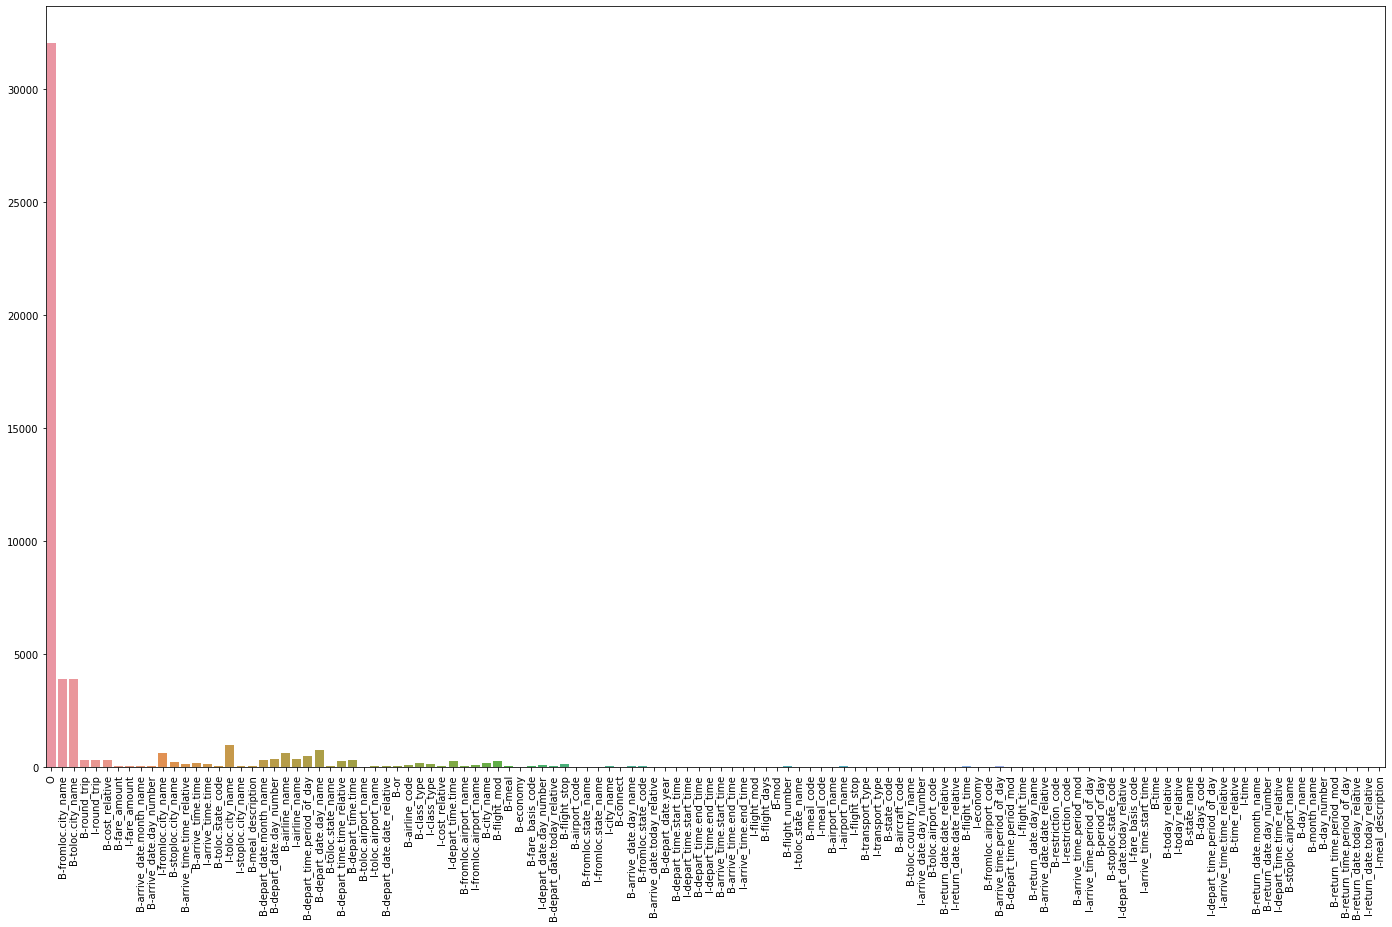

In [19]:
plt.figure(figsize=(24, 14))
sns.barplot(x=list(SLOT_LABEL.vocab.freqs.keys()), y=list(SLOT_LABEL.vocab.freqs.values()))
plt.xticks(rotation=90)
plt.show()

In [20]:
# vocab = SLOT_LABEL.vocab
# freqs_dict = dict(SLOT_LABEL.vocab.freqs)
# slot_distribute = []
# for k in vocab.itos:
#     slot_distribute.append(freqs_dict[k])
# slot_distribute = torch.tensor(slot_distribute, dtype=torch.float32)
# print(slot_distribute)
# print(F.softmax(slot_distribute, 0))

In [21]:
for i, batch in enumerate(test_iter):
    print([TEXT.vocab.itos[i] for i in batch.text[0][:, 0]])
    print(batch.text[1][0])
#     print([(TEXT_EDGE.vocab.itos[i]).split() for i in batch.edge[0][0]])
#     print(batch.edge[1][0])
    break

['list', 'list', 'baltimore', 'las', 'las', 'ground', 'ground', 'what', 'list', 'flights', 'flights', 'what', 'what', 'what', 'what', 'what', 'what', 'what', 'show', 'what', 'does', 'which', 'what', 'what', 'what', 'list', 'list', 'list', 'what', 'what', 'what', 'what', 'what', 'what', 'st.', 'what', 'which', 'which', 'which', 'which', 'what', 'what', 'which', 'what', 'list', 'what', 'what', 'what', 'what', 'what', 'what', 'what', 'minneapolis', 'what', 'what', 'what', 'list', 'list', 'what', 'what', 'list', 'list', 'list', 'list']
tensor(5, device='cuda:0')


In [22]:
"""
Copy file (including metric) from MiuLab:

    https://github.com/MiuLab/SlotGated-SLU
"""


# compute f1 score is modified from conlleval.pl
def __startOfChunk(prevTag, tag, prevTagType, tagType, chunkStart=False):
    if prevTag == 'B' and tag == 'B':
        chunkStart = True
    if prevTag == 'I' and tag == 'B':
        chunkStart = True
    if prevTag == 'O' and tag == 'B':
        chunkStart = True
    if prevTag == 'O' and tag == 'I':
        chunkStart = True

    if prevTag == 'E' and tag == 'E':
        chunkStart = True
    if prevTag == 'E' and tag == 'I':
        chunkStart = True
    if prevTag == 'O' and tag == 'E':
        chunkStart = True
    if prevTag == 'O' and tag == 'I':
        chunkStart = True

    if tag != 'O' and tag != '.' and prevTagType != tagType:
        chunkStart = True
    return chunkStart


def __endOfChunk(prevTag, tag, prevTagType, tagType, chunkEnd=False):
    if prevTag == 'B' and tag == 'B':
        chunkEnd = True
    if prevTag == 'B' and tag == 'O':
        chunkEnd = True
    if prevTag == 'I' and tag == 'B':
        chunkEnd = True
    if prevTag == 'I' and tag == 'O':
        chunkEnd = True

    if prevTag == 'E' and tag == 'E':
        chunkEnd = True
    if prevTag == 'E' and tag == 'I':
        chunkEnd = True
    if prevTag == 'E' and tag == 'O':
        chunkEnd = True
    if prevTag == 'I' and tag == 'O':
        chunkEnd = True

    if prevTag != 'O' and prevTag != '.' and prevTagType != tagType:
        chunkEnd = True
    return chunkEnd


def __splitTagType(tag):
    s = tag.split('-')
    if len(s) > 2 or len(s) == 0:
        raise ValueError('tag format wrong. it must be B-xxx.xxx')
    if len(s) == 1:
        tag = s[0]
        tagType = ""
    else:
        tag = s[0]
        tagType = s[1]
    return tag, tagType


def computeF1Score(correct_slots, pred_slots):
    correctChunk = {}
    correctChunkCnt = 0.0
    foundCorrect = {}
    foundCorrectCnt = 0.0
    foundPred = {}
    foundPredCnt = 0.0
    correctTags = 0.0
    tokenCount = 0.0
    for correct_slot, pred_slot in zip(correct_slots, pred_slots):
        inCorrect = False
        lastCorrectTag = 'O'
        lastCorrectType = ''
        lastPredTag = 'O'
        lastPredType = ''
        for c, p in zip(correct_slot, pred_slot):
            correctTag, correctType = __splitTagType(c)
            predTag, predType = __splitTagType(p)

            if inCorrect == True:
                if __endOfChunk(lastCorrectTag, correctTag, lastCorrectType, correctType) == True and \
                    __endOfChunk(lastPredTag, predTag, lastPredType, predType) == True and \
                    (lastCorrectType == lastPredType):
                    inCorrect = False
                    correctChunkCnt += 1.0
                    if lastCorrectType in correctChunk:
                        correctChunk[lastCorrectType] += 1.0
                    else:
                        correctChunk[lastCorrectType] = 1.0
                elif __endOfChunk(lastCorrectTag, correctTag, lastCorrectType, correctType) != \
                    __endOfChunk(lastPredTag, predTag, lastPredType, predType) or \
                    (correctType != predType):
                    inCorrect = False

            if __startOfChunk(lastCorrectTag, correctTag, lastCorrectType, correctType) == True and \
                __startOfChunk(lastPredTag, predTag, lastPredType, predType) == True and \
                (correctType == predType):
                inCorrect = True

            if __startOfChunk(lastCorrectTag, correctTag, lastCorrectType, correctType) == True:
                foundCorrectCnt += 1
                if correctType in foundCorrect:
                    foundCorrect[correctType] += 1.0
                else:
                    foundCorrect[correctType] = 1.0

            if __startOfChunk(lastPredTag, predTag, lastPredType, predType) == True:
                foundPredCnt += 1.0
                if predType in foundPred:
                    foundPred[predType] += 1.0
                else:
                    foundPred[predType] = 1.0

            if correctTag == predTag and correctType == predType:
                correctTags += 1.0

            tokenCount += 1.0

            lastCorrectTag = correctTag
            lastCorrectType = correctType
            lastPredTag = predTag
            lastPredType = predType

        if inCorrect == True:
            correctChunkCnt += 1.0
            if lastCorrectType in correctChunk:
                correctChunk[lastCorrectType] += 1.0
            else:
                correctChunk[lastCorrectType] = 1.0

    if foundPredCnt > 0:
        precision = 1.0 * correctChunkCnt / foundPredCnt
    else:
        precision = 0

    if foundCorrectCnt > 0:
        recall = 1.0 * correctChunkCnt / foundCorrectCnt
    else:
        recall = 0

    if (precision + recall) > 0:
        f1 = (2.0 * precision * recall) / (precision + recall)
    else:
        f1 = 0

    return f1, precision, recall

pred_slot = [['O', 'O', 'B-airport_code', 'I-airport_code'], ['O', 'O', 'B-airport_code', 'I-airport_code']]
real_slot = [['O', 'O', 'B-airport_code', 'I-airport_code'], ['O', 'O', 'B-airport_code', 'I-airport_code']]
slot_f1_socre = computeF1Score(pred_slot, real_slot)[0]
print(slot_f1_socre)

1.0


## 6. Create Model

In [23]:
# gnn_msg = fn.u_mul_e('h', 'w', 'm')
# gnn_reduce = fn.max('m', 'h')
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [24]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation
        self.gru = nn.GRUCell(out_feats, out_feats)
    def forward(self, node):
        h = self.linear(node.data['h'])
        if self.activation is not None:
            h = self.activation(h)
        old_h = node.data['h']
        h = F.relu(self.gru(h, old_h))
        return {'h': h}

In [25]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation=None):
        super(GCN, self).__init__()
        self.node_apply_module = NodeApplyModule(in_feats, out_feats, activation)
    def forward(self, g, feature):
        if feature is not None:
            g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(self.node_apply_module)
        return g.ndata.pop('h')

In [26]:
# # test_msg = fn.copy_u(u='z', out='m')
# # def udf_u_e(edges):
# #     print(edges.src['z'].shape)
# #     return {'m' : edges.src['z']}
# # test_reduce = fn.sum(msg='m', out='h')

# class MyGATLayer(nn.Module):
#     def __init__(self, in_dim, out_dim, dropout):
#         super(MyGATLayer, self).__init__()
#         # equation (1)
#         self.fc = nn.Linear(in_dim, out_dim, bias=False)
#         # equation (2)
#         self.attn_fc_l = nn.Linear(in_dim, 1, bias=False)
#         self.attn_fc_r = nn.Linear(in_dim, 1, bias=False)
#         self.gru = nn.GRUCell(out_dim, out_dim)
# #         self.dropout = nn.Dropout(p=dropout)
#         self.reset_parameters()
    
#     def myinitializer(shape, dtype, ctx, id_range):
#         return torch.zeros(shape, dtype=dtype, device=ctx)

#     def reset_parameters(self):
#         """Reinitialize learnable parameters."""
#         gain = nn.init.calculate_gain('relu')
#         nn.init.xavier_normal_(self.fc.weight, gain=gain)
#         nn.init.xavier_normal_(self.attn_fc_l.weight, gain=gain)
#         nn.init.xavier_normal_(self.attn_fc_r.weight, gain=gain)

# #     def reduce_func(self, nodes):
# #         # reduce UDF for equation (3) & (4)
# #         # equation (3)
# #         alpha = F.softmax(nodes.mailbox['e'], dim=1)
# #         # equation (4)
# #         h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        
# #         old_h = nodes.data['h']
# # #         h = F.relu(self.gru(h, old_h))
# # #         h = old_h + F.relu(self.gru(h, old_h))
# # #         h = old_h + self.dropout(F.relu(self.gru(h, old_h)))

# # #         print('h', h)
# #         return {'h': h}

#     def forward(self, g, h):
#         # equation (1)
#         feat_src = feat_dst = self.fc(h)
# #         g.ndata['z'] = z
        
#         el = self.attn_fc_l(feat_src)
#         er = self.attn_fc_r(feat_dst)
        
#         g.srcdata.update({'ft': feat_src, 'el': el})
#         g.dstdata.update({'er': er})
        
#         g.set_n_initializer(self.myinitializer)
#         g.set_e_initializer(self.myinitializer)
        
#         # compute edge attention, el and er are a_l Wh_i and a_r Wh_j respectively.
#         g.apply_edges(fn.u_add_v('el', 'er', 'e'))
#         a = F.leaky_relu(g.edata.pop('e'))
        
#         # compute softmax
#         g.edata['a'] = edge_softmax(g, a)

#         # message passing
#         g.update_all(fn.u_mul_e('ft', 'a', 'm'), fn.sum('m', 'h'))
# #         g.update_all(fn.copy_u('ft' ,'m'), fn.sum('m', 'h'))
# #         g.update_all(fn.u_add_v('ft', 'ft', 'm'), fn.max('m', 'h'))
    

#         h = g.ndata.pop('h')
#         h = F.relu(self.gru(h, feat_dst))
# # #         h = old_h + F.relu(self.gru(h, old_h))
# # #         h = old_h + self.dropout(F.relu(self.gru(h, old_h)))
        
#         return h

In [27]:
# test_msg = fn.copy_u(u='z', out='m')
# def udf_u_e(edges):
# #     print(edges.src['z'].shape)
#     return {'m' : edges.src['z']}
# test_reduce = fn.sum(msg='m', out='h')

# def myinitializer(shape, dtype, ctx, id_range):
#     return torch.zeros(shape, dtype=dtype, device=ctx)

class MyGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout):
        super(MyGATLayer, self).__init__()
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.gru = nn.GRUCell(out_dim, out_dim)
#         self.dropout = nn.Dropout(p=dropout)
        self.reset_parameters()
    
#     def myinitializer(shape, dtype, ctx, id_range):
#         return torch.zeros(shape, dtype=dtype, device=ctx)

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        
        old_h = nodes.data['h']
        h = F.relu(self.gru(h, old_h))
#         h = old_h + F.relu(self.gru(h, old_h))
#         h = self.dropout(F.relu(self.gru(h, old_h)))

#         print('h', h)
        return {'h': h}

    def forward(self, g, h):
        # equation (1)
        z = self.fc(h)        
        g.ndata['z'] = z
        
        g.set_n_initializer(dgl.init.zero_initializer)
        g.set_e_initializer(dgl.init.zero_initializer)
        
        # equation (2)
        g.apply_edges(self.edge_attention)
        # equation (3) & (4)
#         g.update_all(udf_u_e, test_reduce)
#         g.update_all(test_msg, test_reduce)
        g.update_all(self.message_func, self.reduce_func)

        return g.ndata.pop('h')

In [28]:
etypes = torch.tensor([1,0,0,0,1,1,1,0])
eids = (etypes == 0).nonzero().view(-1)
print(eids)

tensor([1, 2, 3, 7])


In [29]:
# Sends a message of node feature h.
msg = fn.copy_e(e='W_e*h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.sum(nodes.mailbox['m'], 1)
    return {'h': accum}

class ReduceApplyModule(nn.Module):
    
    def __init__(self, in_feats, out_feats, dropout):
        super(ReduceApplyModule, self).__init__()
        self.gru = nn.GRUCell(in_feats, out_feats)
        self.lstm = nn.LSTMCell(in_feats, out_feats)
        self.norm = nn.LayerNorm(out_feats)
        self.linear = nn.Linear(in_feats, out_feats)
        self.dropout = nn.Dropout(p=dropout)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.gru.reset_parameters()
#         self.lstm.reset_parameters()
    
    def forward(self, nodes):
        """Take an average over all neighbor node features hu and use it to
        overwrite the original node feature."""
#         print(nodes.mailbox['m'].size())
        accum = torch.max(nodes.mailbox['m'], 1)[0]
#         accum = torch.sum(nodes.mailbox['m'], 1)
#         print(nodes.data['h'].size(), accum.size())
        old_h = nodes.data['h']
#         lstm = self.lstm(accum, (old_h, old_h))[0]
        h = old_h + self.dropout(F.relu(self.gru(accum, old_h)))
#         h = old_h + F.dropout(F.relu(self.lstm(accum, (old_h, old_h))[0]), p=dropout)
#         h = F.dropout(F.relu(self.gru(accum, old_h)), p=dropout)
#         h = old_h + F.dropout(F.relu(self.linear(accum)))

#         h = F.dropout(F.relu(lstm), p=dropout)
#         h = self.norm(h)
        return {'h': h}

class EdgeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, dropout):
        super(EdgeApplyModule, self).__init__()
        self.linear_intent = nn.Linear(in_feats, out_feats)
        self.linear_slot = nn.Linear(in_feats, out_feats)

    def forward(self, edges):
        print(edges.data['etype'])
        if edges.data['etype'] == 1:
            h = self.linear_slot(edges.src['h'])
        else:
            h = self.linear_intent(edges.src['h'])
        h = torch.tanh(h)
#         h = F.dropout(F.relu(h))
        return {'W_e*h' : h}

class MyGraph(nn.Module):
    def __init__(self, in_feats, out_feats, n_etypes, dropout):
        super(MyGraph, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
#         self.edge_apply_module = EdgeApplyModule(in_feats, out_feats, dropout)
        self.reduce_apply_module = ReduceApplyModule(in_feats, out_feats, dropout)
        self._n_etypes = n_etypes
        self.linears = nn.ModuleList(
            [nn.Linear(out_feats, out_feats) for _ in range(n_etypes)]
        )
        self.reset_parameters()
    
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = init.calculate_gain('relu')
        for linear in self.linears:
            init.xavier_normal_(linear.weight, gain=gain)
            init.zeros_(linear.bias)
        
    def forward(self, g, feats, etypes):
        g.ndata['h'] = feats
        for i in range(self._n_etypes):
            eids = (etypes == i).nonzero().view(-1)
            g.apply_edges(
                lambda edges: {'W_e*h': torch.tanh(self.linears[i](edges.src['h']))},
                eids
            )
        g.update_all(msg, self.reduce_apply_module)
#         g.update_all(msg, reduce)
#         max_nodes = dgl.max_nodes(g, feat='h')
        feats = g.ndata.pop('h')
        return feats

#     def forward(self, g, feats):
#         g.ndata['h'] = feats
#         g.apply_edges(
#             lambda edges: {'W_e*h': self.linears[0](edges.src['h'])}
#         )
#         g.update_all(msg, self.reduce_apply_module)
# #         g.update_all(msg, reduce)
# #         max_nodes = dgl.max_nodes(g, feat='h')
#         feats = g.ndata.pop('h')
#         return feats

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit([1, 2, 2, 6])

le.classes_, le.transform([1, 1, 2, 6]), le.inverse_transform([0, 0, 1, 2]), le.transform([1]), tuple([1, 2])

(array([1, 2, 6]),
 array([0, 0, 1, 2]),
 array([1, 1, 2, 6]),
 array([0]),
 (1, 2))

In [31]:
import numpy
alist = [1, 2, 1, 6]
blist = [1, 2, 6]
[alist.index(b) for b in blist]

[0, 1, 3]

In [32]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

seq = torch.tensor([[4,5,6], [1,2,0], [3,0,0]])
lens = [3, 2, 1]
packed = pack_padded_sequence(seq, lens, batch_first=False)
print(packed)
# PackedSequence(data=tensor([4, 1, 3, 5, 2, 6]), batch_sizes=tensor([3, 2, 1]),
#                sorted_indices=tensor([2, 0, 1]), unsorted_indices=tensor([1, 2, 0]))
seq_unpacked, lens_unpacked = pad_packed_sequence(packed, batch_first=False)
print(seq_unpacked)
# tensor([[1, 2, 0],
#         [3, 0, 0],
#         [4, 5, 6]])
print(lens_unpacked)
# tensor([2, 1, 3])

PackedSequence(data=tensor([4, 5, 6, 1, 2, 3]), batch_sizes=tensor([3, 2, 1]), sorted_indices=None, unsorted_indices=None)
tensor([[4, 5, 6],
        [1, 2, 0],
        [3, 0, 0]])
tensor([3, 2, 1])


In [33]:
def generate_dglgraph(text, text_include_length, text_edge, text_edge_include_length, text_embedding, edge_embedding):
    sub_graphs = []
    for i in range(len(text)):
        sub_graph = dgl.DGLGraph()
        # preprocessing nodes
        doc = text[i][:text_include_length[i]]
        doc_encoder = LabelEncoder()
        doc_encoder.fit_transform(doc.cpu().numpy())
        
        node_index_select = [doc.cpu().numpy().tolist().index(item) for item in doc_encoder.classes_]
        
        sub_graph.add_nodes(len(doc_encoder.classes_), {'h': torch.index_select(text_embedding[i], 0, torch.tensor(node_index_select).to(device))})
        # preprocessing edges
        doc_edge = text_edge[i][:text_edge_include_length[i]]
        
        new_edge_list = []
        edge_index_select = []
        for j in range(len(doc_edge)):
            edge_key_split = (TEXT_EDGE.vocab.itos[doc_edge[j]]).split()
            if len(edge_key_split) == 2:
                src = TEXT.vocab.stoi[edge_key_split[0]]
                dst = TEXT.vocab.stoi[edge_key_split[1]]
                new_edge_list.append(tuple(doc_encoder.transform([src, dst])))
                edge_index_select.append(j)
        
        new_src, new_dst = tuple(zip(*new_edge_list))
        
        sub_graph.add_edges(new_src, new_dst, {'w':torch.index_select(edge_embedding[i], 0, torch.tensor(edge_index_select).to(device))})
        # summary
        sub_graphs.append(sub_graph)
    return sub_graphs

In [34]:
def generate_dglgraph(x, x_length):
    sub_graphs = []
    for i in range(len(x)):
        sub_graph = dgl.DGLGraph()
        # preprocessing nodes
        sub_graph.add_nodes(x_length[i], {'h':x[i][:x_length[i]]})
        # preprocessing edges
        src, dst = text_edge_tokenize(np.arange(x_length[i]))
        sub_graph.add_edges(src, dst)
        # summary
        sub_graphs.append(sub_graph)
    return sub_graphs

In [35]:
def generate_dglgraph(x, x_length):
    sub_graphs = []
    for i in range(len(x)):
        sub_graph = dgl.DGLGraph()
        # preprocessing nodes
        sub_graph.add_nodes(x_length[i], {'h':x[i][:x_length[i]]})
        # preprocessing edges
        sub_graph.add_edges(0, range(1, x_length[i]))
        sub_graph.add_edges(range(1, x_length[i]), 0)
        sub_graph.add_edges(range(1, x_length[i]), list(range(2, x_length[i]))+[1])
        sub_graph.add_edges(list(range(2, x_length[i]))+[1], range(1, x_length[i]))
#         sub_graph.add_edges(range(x_length[i]), range(x_length[i]))
        
        # summary
        sub_graphs.append(sub_graph)
    return sub_graphs

In [36]:
def generate_dglgraph(x, x_intent, x_length):
    sub_graphs = []
    for i in range(len(x)):
        sub_graph = dgl.DGLGraph()
        # preprocessing nodes
        sub_graph.add_nodes(1, {'h': x_intent[i].unsqueeze(0)})
        sub_graph.add_nodes(x_length[i], {'h':x[i][:x_length[i]]})
        # preprocessing edges
#         sub_graph.add_edges(0, range(1, x_length[i]+1), {'etype': torch.zeros(x_length[i])})
#         sub_graph.add_edges(range(1, x_length[i]+1), 0, {'etype': torch.zeros(x_length[i])})
#         sub_graph.add_edges(range(1, x_length[i]+1), list(range(2, x_length[i]+1))+[1], {'etype': torch.ones(x_length[i])})
#         sub_graph.add_edges(list(range(2, x_length[i]+1))+[1], range(1, x_length[i]+1), {'etype': torch.ones(x_length[i])})
#         sub_graph.add_edges(range(x_length[i]+1), range(x_length[i]+1), {'etype': torch.ones(x_length[i]+1)+1})

        sub_graph.add_edges(0, range(1, x_length[i]+1))
        sub_graph.add_edges(range(1, x_length[i]+1), 0)
        sub_graph.add_edges(range(1, x_length[i]+1), list(range(2, x_length[i]+1))+[1])
        sub_graph.add_edges(list(range(2, x_length[i]+1))+[1], range(1, x_length[i]+1))
#         sub_graph.add_edges(range(1, x_length[i]), list(range(2, x_length[i]+1)))
#         sub_graph.add_edges(list(range(2, x_length[i]+1)), range(1, x_length[i]))
        
        sub_graph.add_edges(range(x_length[i]+1), range(x_length[i]+1))
        
        # summary
        sub_graphs.append(sub_graph)
    return sub_graphs

torch.Size([4, 5, 2])
{'h': tensor([[1, 1],
        [1, 1],
        [2, 2],
        [3, 3],
        [4, 4],
        [5, 5]])}
{}


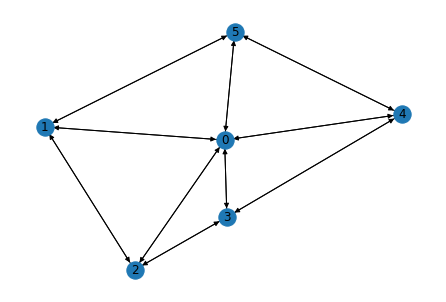

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
x = torch.tensor([
    [[1, 1],[2, 2],[3, 3],[4, 4],[5, 5]],
    [[5, 5],[6, 6],[7, 7],[1, 1],[0, 0]],
    [[7, 8],[9, 4],[10, 4],[0, 0],[0, 0]],
    [[8, 8],[9, 9],[0, 0],[0, 0],[0, 0]]
])
x_intent = torch.tensor([
    [1,1],[2,2],[3,3],[4,4]
])
print(x.size())
x_length = torch.tensor([5, 4, 3, 2])
# sub_graphs = generate_dglgraph(x, x_length)
sub_graphs = generate_dglgraph(x, x_intent, x_length)
g = sub_graphs[0]
print(g.ndata)
print(g.edata)
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

In [38]:
a = list(range(1, 7)) + [1]
a

[1, 2, 3, 4, 5, 6, 1]

In [39]:
x = torch.tensor([
    [1, 1],[2, 2],[3, 3],[4, 4],
    [5, 5],[6, 6],[7, 7],
    [8, 8],[9, 9]
])
x_length = torch.tensor([4, 3, 2])
print(x.size(), x_length.size())
packed_sequence = nn.utils.rnn.PackedSequence(data=x, batch_sizes=x_length)
x = nn.utils.rnn.pad_packed_sequence(packed_sequence, batch_first=False)
print(x, x[0].size())
# print(x[0].transpose(0, 1))
print(x[0][:,0])
print(x[0][:,1:])
print(x_length-1)

torch.Size([9, 2]) torch.Size([3])
(tensor([[[1, 1],
         [2, 2],
         [3, 3],
         [4, 4]],

        [[5, 5],
         [6, 6],
         [7, 7],
         [0, 0]],

        [[8, 8],
         [9, 9],
         [0, 0],
         [0, 0]]]), tensor([3, 3, 2, 1])) torch.Size([3, 4, 2])
tensor([[1, 1],
        [5, 5],
        [8, 8]])
tensor([[[2, 2],
         [3, 3],
         [4, 4]],

        [[6, 6],
         [7, 7],
         [0, 0]],

        [[9, 9],
         [0, 0],
         [0, 0]]])
tensor([3, 2, 1])


In [40]:
m = torch.tensor([
    [[1,1],[2,2]],
    [[4,4],[3,3]],
    [[5,7],[6,4]]
], dtype=torch.float32)
# m = m.transpose(0,1)
print(m)
print(m.size())
out = torch.max(m, 1)
print(out)
out = torch.mean(m, 1)
print(out)

tensor([[[1., 1.],
         [2., 2.]],

        [[4., 4.],
         [3., 3.]],

        [[5., 7.],
         [6., 4.]]])
torch.Size([3, 2, 2])
torch.return_types.max(
values=tensor([[2., 2.],
        [4., 4.],
        [6., 7.]]),
indices=tensor([[1, 1],
        [0, 0],
        [1, 0]]))
tensor([[1.5000, 1.5000],
        [3.5000, 3.5000],
        [5.5000, 5.5000]])


In [41]:
hidden = torch.tensor([
    [[1,1,1],[2,2,2],[3,3,3]],
    [[4,4,4],[5,5,5],[6,6,6]]
])
print(hidden.size())
print(torch.cat(tuple([hidden[i] for i in range(hidden.size(0))]), 1))

torch.Size([2, 3, 3])
tensor([[1, 1, 1, 4, 4, 4],
        [2, 2, 2, 5, 5, 5],
        [3, 3, 3, 6, 6, 6]])


In [42]:
def generate_key_padding_mask(include_length): # return (N,L)
    max_length = torch.max(include_length)
#     print([torch.arange(max_length)>=i for i in include_length])
    mask = torch.stack([torch.arange(max_length)>=i for i in include_length])
    return mask
    
include_length = torch.tensor([6, 4, 3, 2])
generate_key_padding_mask(include_length)

tensor([[False, False, False, False, False, False],
        [False, False, False, False,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False,  True,  True,  True,  True]])

In [43]:
def generate_key_padding_mask(include_length): # return (N,L,L)
    max_length = torch.max(include_length)
#     print([torch.arange(max_length)>=i for i in include_length])
    mask = torch.stack([torch.arange(max_length).to(device)>=i for i in include_length])
    mask = mask.unsqueeze(1).expand(-1, mask.size(1), -1)
    return mask
    
include_length = torch.tensor([6, 4, 3, 2]).to(device)
generate_key_padding_mask(include_length)

tensor([[[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]],

        [[False, False, False, False,  True,  True],
         [False, False, False, False,  True,  True],
         [False, False, False, False,  True,  True],
         [False, False, False, False,  True,  True],
         [False, False, False, False,  True,  True],
         [False, False, False, False,  True,  True]],

        [[False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True]],

        [[False, False,  True,  True,  T

In [44]:
def generate_square_subsequent_mask(q):
    r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).
    """
    mask = (torch.triu(torch.ones(q.size(1), q.size(1)).to(device), 1) == 1)
#     mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask = mask.unsqueeze(0).expand(q.size(0), -1, -1)  # [B, L, L]
    return mask
q = torch.tensor([
    [[1,1,1],[2,2,2],[3,3,3], [1,1,1],[2,2,2],[3,3,3]],
    [[4,4,4],[5,5,5],[6,6,6], [4,4,4],[5,5,5],[6,6,6]]
]).to(device)
generate_square_subsequent_mask(q)

tensor([[[False,  True,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False, False,  True,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False, False]],

        [[False,  True,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False, False,  True,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False, False]]], device='cuda:0')

In [45]:
class ScaledDotProductAttention(nn.Module):
    
    def __init__(self, dropout):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, q, k, v, scale=None, attn_mask=None):
        '''
        前向传播

        args:
            q: Queries张量，形状[B, L_q, D_q]
            k: keys张量， 形状[B, L_k, D_k]
            v: Values张量，形状[B, L_v, D_v]
            scale: 缩放因子，一个浮点标量
            attn_mask: Masking张量，形状[B, L_q, L_k]
        returns:
            上下文张量和attention张量
        '''
        attn = torch.bmm(q, k.transpose(1,2))
        if scale:
            attn = attn * scale
#         if attn_mask:
            # 给需要mask的地方设置一个负无穷
        attn = attn.masked_fill(attn_mask, -np.inf)
        # 计算softmax
        attn = self.softmax(attn)
        # 添加dropout
        attn = self.dropout(attn)
        # 和v相乘
        context = torch.bmm(attn, v)
        
        return context, attn

In [46]:
# 支持多分类和二分类
class FocalLoss(nn.Module):
  """
  This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
  "Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)"
    Focal_Loss= -1*alpha*(1-pt)^gamma*log(pt)
  :param num_class:
  :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
  :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
          focus on hard misclassified example
  :param smooth: (float,double) smooth value when cross entropy
  :param balance_index: (int) balance class index, should be specific when alpha is float
  :param size_average: (bool, optional) By default, the losses are averaged over each loss element in the batch.
  """
 
  def __init__(self, num_class, alpha=None, gamma=2, balance_index=-1, smooth=None, size_average=True):
    super(FocalLoss, self).__init__()
    self.num_class = num_class
    self.alpha = alpha
    self.gamma = gamma
    self.smooth = smooth
    self.size_average = size_average
 
    if self.alpha is None:
      self.alpha = torch.ones(self.num_class, 1)
    elif isinstance(self.alpha, (list, np.ndarray)):
      assert len(self.alpha) == self.num_class
      self.alpha = torch.FloatTensor(alpha).view(self.num_class, 1)
      self.alpha = self.alpha / self.alpha.sum()
    elif isinstance(self.alpha, float):
      alpha = torch.ones(self.num_class, 1)
      alpha = alpha * (1 - self.alpha)
      alpha[balance_index] = self.alpha
      self.alpha = alpha
    else:
      raise TypeError("Not support alpha type")
 
    if self.smooth is not None:
      if self.smooth < 0 or self.smooth > 1.0:
        raise ValueError("smooth value should be in [0,1]")
 
  def forward(self, input, target):
    logit = F.softmax(input, dim=1)
 
    if logit.dim() > 2:
      # N,C,d1,d2 -> N,C,m (m=d1*d2*...)
      logit = logit.view(logit.size(0), logit.size(1), -1)
      logit = logit.permute(0, 2, 1).contiguous()
      logit = logit.view(-1, logit.size(-1))
    target = target.view(-1, 1)
 
    # N = input.size(0)
    # alpha = torch.ones(N, self.num_class)
    # alpha = alpha * (1 - self.alpha)
    # alpha = alpha.scatter_(1, target.long(), self.alpha)
    epsilon = 1e-10
    alpha = self.alpha
    if alpha.device != input.device:
      alpha = alpha.to(input.device)
 
    idx = target.cpu().long()
    one_hot_key = torch.FloatTensor(target.size(0), self.num_class).zero_()
    one_hot_key = one_hot_key.scatter_(1, idx, 1)
    if one_hot_key.device != logit.device:
      one_hot_key = one_hot_key.to(logit.device)
 
    if self.smooth:
      one_hot_key = torch.clamp(
        one_hot_key, self.smooth, 1.0 - self.smooth)
    pt = (one_hot_key * logit).sum(1) + epsilon
    logpt = pt.log()
 
    gamma = self.gamma
 
    alpha = alpha[idx]
    loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt
 
    if self.size_average:
      loss = loss.mean()
    else:
      loss = loss.sum()
    return loss
 
 
 
class BCEFocalLoss(torch.nn.Module):
  """
  二分类的Focalloss alpha 固定
  """
  def __init__(self, gamma=2, alpha=0.25, reduction="elementwise_mean"):
    super().__init__()
    self.gamma = gamma
    self.alpha = alpha
    self.reduction = reduction
 
  def forward(self, _input, target):
    pt = torch.sigmoid(_input)
    alpha = self.alpha
    loss = - alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - (1 - alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt)
    if self.reduction == "elementwise_mean":
      loss = torch.mean(loss)
    elif self.reduction == "sum":
      loss = torch.sum(loss)
    return loss
 

In [47]:
"""Torch Module for GraphSAGE layer"""
# pylint: disable= no-member, arguments-differ, invalid-name

class SAGEConv(nn.Module):
    r"""GraphSAGE layer from paper `Inductive Representation Learning on
    Large Graphs <https://arxiv.org/pdf/1706.02216.pdf>`__.

    .. math::
        h_{\mathcal{N}(i)}^{(l+1)} & = \mathrm{aggregate}
        \left(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)

        h_{i}^{(l+1)} & = \sigma \left(W \cdot \mathrm{concat}
        (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1} + b) \right)

        h_{i}^{(l+1)} & = \mathrm{norm}(h_{i}^{l})

    Parameters
    ----------
    in_feats : int
        Input feature size.
    out_feats : int
        Output feature size.
    feat_drop : float
        Dropout rate on features, default: ``0``.
    aggregator_type : str
        Aggregator type to use (``mean``, ``gcn``, ``pool``, ``lstm``).
    bias : bool
        If True, adds a learnable bias to the output. Default: ``True``.
    norm : callable activation function/layer or None, optional
        If not None, applies normalization to the updated node features.
    activation : callable activation function/layer or None, optional
        If not None, applies an activation function to the updated node features.
        Default: ``None``.
    """
    def __init__(self,
                 in_feats,
                 out_feats,
                 aggregator_type,
                 feat_drop=0.,
                 bias=True,
                 norm=None,
                 activation=None):
        super(SAGEConv, self).__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._aggre_type = aggregator_type
        self.norm = norm
        self.feat_drop = nn.Dropout(feat_drop)
        self.activation = activation
        # aggregator type: mean/pool/lstm/gcn
        if aggregator_type == 'pool':
            self.fc_pool = nn.Linear(in_feats, in_feats)
        if aggregator_type == 'gru':
            self.gru = nn.GRU(in_feats, in_feats, batch_first=True)
        if aggregator_type != 'gcn':
            self.fc_self = nn.Linear(in_feats, out_feats, bias=bias)
        self.fc_neigh = nn.Linear(in_feats, out_feats, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        if self._aggre_type == 'pool':
            nn.init.xavier_uniform_(self.fc_pool.weight, gain=gain)
        if self._aggre_type == 'gru':
            self.gru.reset_parameters()
        if self._aggre_type != 'gcn':
            nn.init.xavier_uniform_(self.fc_self.weight, gain=gain)
        nn.init.xavier_uniform_(self.fc_neigh.weight, gain=gain)

    def _gru_reducer(self, nodes):
        """LSTM reducer
        NOTE(zihao): lstm reducer with default schedule (degree bucketing)
        is slow, we could accelerate this with degree padding in the future.
        """
        m = nodes.mailbox['m'] # (B, L, D)
        batch_size = m.shape[0]
#         h = (m.new_zeros((1, batch_size, self._in_feats)),
#              m.new_zeros((1, batch_size, self._in_feats)))
        h = m.new_zeros((1, batch_size, self._in_feats))
#         _, (rst, _) = self.gru(m, h)
        _, rst = self.gru(m, h)
        return {'neigh': rst.squeeze(0)}

    def forward(self, graph, feat):
        r"""Compute GraphSAGE layer.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor
            The input feature of shape :math:`(N, D_{in})` where :math:`D_{in}`
            is size of input feature, :math:`N` is the number of nodes.

        Returns
        -------
        torch.Tensor
            The output feature of shape :math:`(N, D_{out})` where :math:`D_{out}`
            is size of output feature.
        """
        graph = graph.local_var()
        feat = self.feat_drop(feat)
        h_self = feat
        if self._aggre_type == 'mean':
            graph.ndata['h'] = feat
            graph.update_all(fn.copy_src('h', 'm'), fn.mean('m', 'neigh'))
            h_neigh = graph.ndata['neigh']
        elif self._aggre_type == 'gcn':
            graph.ndata['h'] = feat
            graph.update_all(fn.copy_src('h', 'm'), fn.sum('m', 'neigh'))
            # divide in_degrees
            degs = graph.in_degrees().float()
            degs = degs.to(feat.device)
            h_neigh = (graph.ndata['neigh'] + graph.ndata['h']) / (degs.unsqueeze(-1) + 1)
        elif self._aggre_type == 'pool':
            graph.ndata['h'] = F.relu(self.fc_pool(feat))
            graph.update_all(fn.copy_src('h', 'm'), fn.max('m', 'neigh'))
            h_neigh = graph.ndata['neigh']
        elif self._aggre_type == 'gru':
            graph.ndata['h'] = feat
            graph.update_all(fn.copy_src('h', 'm'), self._gru_reducer)
            h_neigh = graph.ndata['neigh']
        else:
            raise KeyError('Aggregator type {} not recognized.'.format(self._aggre_type))
        # GraphSAGE GCN does not require fc_self.
        if self._aggre_type == 'gcn':
            rst = self.fc_neigh(h_neigh)
        else:
            rst = self.fc_self(h_self) + self.fc_neigh(h_neigh)
        # activation
        if self.activation is not None:
            rst = self.activation(rst)
        # normalization
        if self.norm is not None:
            rst = self.norm(rst)
        return rst

In [48]:
class Net(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_heads, hidden_dim, edge_dim, dropout, intent_output_dim, slot_output_dim):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim) # 512
#         nn.init.kaiming_normal_(self.embedding.weight, mode='fan_out', nonlinearity='relu')
        self.linear = nn.Linear(embedding_dim, embedding_dim)
        self.multiheadAttention = nn.MultiheadAttention(embedding_dim, num_heads, dropout) # 512
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True) # 512
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=dropout) # 512
        self.gru1 = nn.GRU(embedding_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True) # 512
        self.gru2 = nn.GRU(embedding_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True) # 512
        self.edge_dim = edge_dim
        self.gcn = GCN(embedding_dim, embedding_dim, F.relu)
        self.gcn1 = GCN(embedding_dim, 512, F.relu)
        self.gcn2 = GCN(512, 1024, F.relu)
        self.gatedGraphConv = conv.GatedGraphConv(embedding_dim, 512, 4, 1)
        self.gatConv = conv.GATConv(embedding_dim, 64, num_heads=8, residual=True)
        self.sageConv = SAGEConv(embedding_dim, embedding_dim, aggregator_type='gru', feat_drop=dropout, activation=F.relu)
        self.myGraph = MyGraph(embedding_dim, embedding_dim, 3, dropout)
        self.myGat = MyGATLayer(embedding_dim, embedding_dim, dropout)
#         self.myGat = MyGATLayer(embedding_dim, embedding_dim, 0.0)
        self.selfAttention = ScaledDotProductAttention(dropout)
        self.linear1 = nn.Linear(2*hidden_dim, intent_output_dim)
        self.linear2 = nn.Linear(2*hidden_dim, slot_output_dim)
        self.bilinear1 = nn.Bilinear(embedding_dim, embedding_dim, slot_output_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.dropout4 = nn.Dropout(dropout)
        
    def forward(self, x):
        text, text_include_length = x
#         print(text.size())
#         print(text_include_length.size())
#         print(text_include_length-1)
#         print(torch.sum(text_include_length-1))
#         text_embedding = self.embedding(text)
        text_embedding = self.embedding(text)
#         print(text_embedding)
#         text_embedding = self.linear(text_embedding)
        text_embedding = self.dropout1(text_embedding)
        text_embedding = self.dropout1(self.linear(text_embedding))
#         print(text_embedding)
        
        # MultiheadAttention
#         attn_output, attn_output_weights = self.multiheadAttention(text_embedding.transpose(0, 1), text_embedding.transpose(0, 1), text_embedding.transpose(0, 1), key_padding_mask=_generate_key_padding_mask(text_include_length).to(device))
#         attn_output = attn_output.transpose(0, 1)
        # TransformerEncoder
#         attn_output = self.transformer_encoder(text_embedding.transpose(0, 1), src_key_padding_mask=_generate_key_padding_mask(text_include_length).to(device))
#         attn_output = attn_output.transpose(0, 1)
        # SelfAttention
#         attn_output, _ = self.selfAttention(text_embedding, text_embedding, text_embedding, attn_mask=generate_key_padding_mask(text_include_length).to(device))
        
        # begin - create dglgraph
#         sub_graphs = generate_dglgraph(text, text_include_length, text_edge, text_edge_include_length, text_embedding, edge_embedding)
        
#         batch_graph = dgl.batch(sub_graphs)
        
#         batch_graph.update_all(message_func=gnn_msg, reduce_func=gnn_reduce)
#         h = dgl.sum_nodes(batch_graph, feat='h')

        # end - create dglgraph
    
    
#...............................................................
    
#         x = out.transpose(0, 1)
#         x_intent = torch.max(x, 1)[0]
#         x = torch.cat([x[i][:text_include_length[i], :] for i in range(0, len(text_include_length))], dim=0)
        
#         x_slot = nn.utils.rnn.pack_padded_sequence(text_embedding, lengths=text_include_length, batch_first=True)
        
        
#         print(batch_graph.ndata['h'].size())
#         print(x.size())
#         print(x_intent.size())

        # two lstm
        x = nn.utils.rnn.pack_padded_sequence(text_embedding, lengths=text_include_length, batch_first=True)
#         output1, hidden1 = self.gru1(x)
#         output2, hidden2 = self.gru2(x)

        # lstm
#         output, (hidden, cell) = self.lstm(x)
        # gru
        output, hidden = self.gru(x)
#         print(output[0].size(), hidden.size())
#         pad_output1, _ = nn.utils.rnn.pad_packed_sequence(output1, batch_first=True)
        pad_output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
#         print(pad_output)
#         x_slot_gru = torch.cat([pad_output[i][:text_include_length[i], :] for i in range(0, len(text_include_length))], dim=0)
#         x_intent = torch.max(pad_output, 1)[0]
        
        # MultiheadAttention
#         attn_output, attn_output_weights = self.multiheadAttention(pad_output.transpose(0, 1), pad_output.transpose(0, 1), pad_output.transpose(0, 1), key_padding_mask=_generate_key_padding_mask(text_include_length).to(device))
#         pad_output = attn_output.transpose(0, 1)
        # SelfAttention
#         pad_output_intent, _ = self.selfAttention(pad_output, pad_output, pad_output, attn_mask=generate_key_padding_mask(text_include_length)) # + generate_square_subsequent_mask(pad_output)
        # SelfAttention
#         pad_output, _ = self.selfAttention(pad_output, pad_output, pad_output, attn_mask=generate_key_padding_mask(text_include_length))
#         print(pad_output.size())
#         print(attn_output.size())
#         pad_output = torch.cat([pad_output, attn_out], dim=2)
#         print(pad_output.size())
#         pad_output = text_embedding
        x_intent = torch.max(pad_output, 1)[0]
#         x_intent = torch.mean(pad_output, 1)
#         x_intent = torch.sum(pad_output, 1)
#         x_intent = torch.cat(tuple([hidden[i] for i in range(hidden.size(0))]), 1)
#         print(x.size())
#         x_intent = x[:,0]
#         x_slot = x[:, 1:]
#         print(x_intent.size())
#         print(x_slot.size())
#         x_slot = torch.cat([pad_output[i][:text_include_length[i], :] for i in range(0, len(text_include_length))], dim=0)
#         print(x_slot.data.size())
#         x_intent = F.dropout(hidden.view(hidden.size(1), -1), p=dropout)
    
#...............................................................     
        sub_graphs = generate_dglgraph(pad_output, x_intent, text_include_length)
        batch_graph = dgl.batch(sub_graphs)
#         etypes = torch.tensor([0]*(np.sum(batch_graph.batch_num_edges)))
#         x = self.gatedGraphConv(batch_graph, batch_graph.ndata['h'], etypes)
#         x = self.gatConv(batch_graph, batch_graph.ndata['h'])
#         x = x.view(x.size(0), -1)
#         x = self.sageConv(batch_graph, batch_graph.ndata['h'])
        x = self.myGat(batch_graph, batch_graph.ndata['h'])
#         x = self.gcn(batch_graph, batch_graph.ndata['h'])
#         feats = batch_graph.ndata['h']
#         etypes = batch_graph.edata['etype']
#         x = self.myGraph(batch_graph, feats, etypes)
#         x = self.myGraph(batch_graph, x, etypes)
#         print('x', x)
#         print(x.size())
#         print(output[0] == x)
#         batch_graph.ndata['h'] = x
#         x_intent = dgl.max_nodes(batch_graph, feat='h')
#         print(x_intent.size())
#         print(batch_graph.batch_size, batch_graph.batch_num_nodes)
#         unbatch_graph = dgl.unbatch(batch_graph)
#         print(unbatch_graph)
        

#...............................................................        
#         sub_graphs = generate_dglgraph(x, text_include_length)
#         batch_graph = dgl.batch(sub_graphs)
#         x = self.gcn1(batch_graph, None)
#         x = self.gcn2(batch_graph, x)

#         batch_graph.ndata['h'] = x
#         x_intent = dgl.max_nodes(batch_graph, feat='h')
#         print(batch_graph.batch_size, batch_graph.batch_num_nodes)
#         unbatch_graph = dgl.unbatch(batch_graph)
#         print(unbatch_graph)

#...............................................................
        packed_sequence = nn.utils.rnn.PackedSequence(data=x, batch_sizes=torch.tensor(batch_graph.batch_num_nodes))
        x = nn.utils.rnn.pad_packed_sequence(packed_sequence, batch_first=False)[0]
#         print('x', x)
#         print(x[0].size())
        x_intent = x[:,0]
#         x_intent = torch.cat([x[:,0], x_intent], dim=1)
        x_slot = x[:, 1:]
#         x_slot = torch.cat([x[:,1:], pad_output], dim=2)
#         print(x_intent.size())
#         print(x_slot.size())
#         text_include_length = text_include_length-1
        x_slot = torch.cat([x_slot[i][:text_include_length[i], :] for i in range(0, len(text_include_length))], dim=0)
#         x_slot = nn.utils.rnn.pack_padded_sequence(x_slot, lengths=text_include_length-1, batch_first=True)
#         print(x_slot[0].size())

        
        # lstm
#         x = nn.utils.rnn.pack_padded_sequence(x_slot, lengths=text_include_length, batch_first=True)
#         output, (hidden, cell) = self.lstm(x)
        # gru
#         output, hidden = self.gru1(x)
#         print(output[0].size(), hidden.size())
#         pad_output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
#         print(pad_output)
#         x_intent = torch.max(pad_output, 1)[0]
#         x_slot = torch.cat([pad_output[i][:text_include_length[i], :] for i in range(0, len(text_include_length))], dim=0)
    
    
        
        x_intent = self.dropout1(x_intent)
        x_intent = F.relu(x_intent)
        x_intent = self.linear1(x_intent)
        
#         x_slot_gru = F.dropout(x_slot_gru, p=dropout)
#         x_slot_gru = F.relu(x_slot_gru)
        
        x_slot = self.dropout1(x_slot)
#         x_slot = F.dropout(x, p= dropout)
#         x_slot = F.dropout(x_slot, p= dropout)
        x_slot = F.relu(x_slot)
        x_slot = self.linear2(x_slot)
#         x_slot = self.bilinear1(x_slot, x_slot_gru)
        
        return x_intent, x_slot

## 7. training and evaluation

In [49]:
from sklearn.metrics import accuracy_score, f1_score
def acc(y_pred, y_true):
    return accuracy_score(y_true, y_pred)
def f_score(y_pred, y_true):
    return f1_score(y_true, y_pred, average='weighted')
def semantic_acc(semantic_slot_pred, semantic_slot_true, semantic_intent_pred, semantic_intent_true):
    num_acc = 0
    for i in range(len(semantic_slot_pred)):
        num_acc += (semantic_slot_pred[i] == semantic_slot_true[i] and semantic_intent_pred[i] == semantic_intent_true[i])
    return num_acc / len(semantic_slot_pred)
    
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
print(acc(y_pred, y_true))
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
print(f_score(y_pred, y_true))
y_pred = [[1,2],[0,1],[1,3],[2,3]]
y_true = [[1,2],[0,1],[1,4],[2,3]]
y_intent_pred = [1,2,3,4]
y_intent_true = [1,2,3,4]
print(y_pred[0] == y_true[0], y_pred[2] == y_true[2])
print(semantic_acc(y_pred, y_true, y_intent_pred, y_intent_true))

x = torch.tensor([[1],[2],[3]])
print(x.size(), x.tolist())

0.5
0.26666666666666666
True False
0.75
torch.Size([3, 1]) [[1], [2], [3]]


In [50]:
def process_semantic_slot(semantic_slot_pred, semantic_slot_true, include_length):
    semantic_pred = []
    semantic_true = []
    i = 0
    for l in include_length:
        semantic_pred.append(semantic_slot_pred[i:i+l])
        semantic_true.append(semantic_slot_true[i:i+l])
        i += l
    return semantic_pred, semantic_true

semantic_slot_pred = [1, 2, 3, 4, 5]
semantic_slot_true = [1, 2, 4, 5, 6]
include_lenght = [3, 1, 1]
# print(semantic_slot_pred[0:2])
process_semantic_slot(semantic_slot_pred, semantic_slot_true, include_lenght)

([[1, 2, 3], [4], [5]], [[1, 2, 4], [5], [6]])

In [51]:
def train(model: nn.Module, 
          iterator: data.BucketIterator, 
          optimizer: optim.Optimizer,
#           scheduler: optim.lr_scheduler,
          criterion: nn.Module, 
          clip: float):
    
    model.train()
    intent_train_loss = 0
    slot_train_loss = 0
    intent_train_pred = []
    slot_train_pred = []
    intent_train_true = []
    slot_train_true = []
    semantic_slot_train_pred = []
    semantic_slot_train_true = []
    
    for _, batch in enumerate(iterator):
        text = batch.text
        slot_target, slot_include_length = batch.slot
        
        intent_target = batch.intent.squeeze(1)
#         slot_target = nn.utils.rnn.pack_padded_sequence(slot_target, slot_include_length, batch_first=True)[0].view(-1)
        slot_target = torch.cat([slot_target[i][:slot_include_length[i]] for i in range(0, len(slot_include_length))], dim=0)
#         print(intent_target.size(), slot_target.size())
        
        intent_output, slot_output = model(text)

#         print(intent_output.size(), slot_output.size())
        
        intent_loss = criterion(intent_output, intent_target)
        slot_loss = criterion(slot_output, slot_target)
        loss = 0.1*intent_loss + 0.9*slot_loss # loss = 0.1*intent_loss + 0.9*slot_loss => ATIS Datasets
        
        
        intent_train_loss += intent_loss.item()
        intent_output = [INTENT_LABEL.vocab.itos[elem] for elem in intent_output.argmax(1)]
        intent_train_pred += intent_output
        intent_target = [INTENT_LABEL.vocab.itos[elem] for elem in intent_target]
        intent_train_true += intent_target
        
        slot_train_loss += slot_loss.item()
        slot_output = [SLOT_LABEL.vocab.itos[elem] for elem in slot_output.argmax(1)]
        slot_train_pred += slot_output
        slot_target = [SLOT_LABEL.vocab.itos[elem] for elem in slot_target]
        slot_train_true += slot_target
        
        semantic_slot_pred, semantic_slot_true = process_semantic_slot(slot_output, slot_target, slot_include_length)
        semantic_slot_train_pred += semantic_slot_pred
        semantic_slot_train_true += semantic_slot_true
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
#         scheduler.step()
    
#     print(intent_train_pred)
#     print(intent_train_true)
    sem_acc = semantic_acc(semantic_slot_train_pred, semantic_slot_train_true, intent_train_pred, intent_train_true)
    return intent_train_loss / len(iterator), acc(intent_train_pred, intent_train_true), slot_train_loss / len(iterator), computeF1Score(semantic_slot_train_true, semantic_slot_train_pred)[0], sem_acc

def evaluate(model: nn.Module,
             iterator: data.BucketIterator,
             criterion: nn.Module):
    
    model.eval()
    epoch_intent_loss = 0
    epoch_slot_loss = 0
    epoch_intent_pred = []
    epoch_slot_pred = []
    epoch_intent_true = []
    epoch_slot_true = []
    epoch_semantic_slot_pred = []
    epoch_semantic_slot_true = []
        
    with torch.no_grad():
        
        for _, batch in enumerate(iterator):
            text = batch.text
            slot_target, slot_include_length = batch.slot
        
            intent_target = batch.intent.squeeze(1)
#             slot_target = nn.utils.rnn.pack_padded_sequence(slot_target, slot_include_length, batch_first=True)[0].view(-1)
            slot_target = torch.cat([slot_target[i][:slot_include_length[i]] for i in range(0, len(slot_include_length))], dim=0)
            
            intent_output, slot_output = model(text)
            
            intent_loss = criterion(intent_output, intent_target)
            slot_loss = criterion(slot_output, slot_target)
            
            epoch_intent_loss += intent_loss.item()
            intent_output = [INTENT_LABEL.vocab.itos[elem] for elem in intent_output.argmax(1)]
            epoch_intent_pred += intent_output
            intent_target = [INTENT_LABEL.vocab.itos[elem] for elem in intent_target]
            epoch_intent_true += intent_target
        
            epoch_slot_loss += slot_loss.item()
            slot_output = [SLOT_LABEL.vocab.itos[elem] for elem in slot_output.argmax(1)]
            epoch_slot_pred += slot_output
            slot_target = [SLOT_LABEL.vocab.itos[elem] for elem in slot_target]
            epoch_slot_true += slot_target
            
            semantic_slot_pred, semantic_slot_true = process_semantic_slot(slot_output, slot_target, slot_include_length)
            epoch_semantic_slot_pred += semantic_slot_pred
            epoch_semantic_slot_true += semantic_slot_true
        
#     print('semantic_slot_pred', semantic_slot_pred)
#     print('semantic_slot_true', semantic_slot_true)
    sem_acc = semantic_acc(epoch_semantic_slot_pred, epoch_semantic_slot_true, epoch_intent_pred, epoch_intent_true)
    
    return epoch_intent_loss / len(iterator), acc(epoch_intent_pred, epoch_intent_true), epoch_slot_loss / len(iterator), computeF1Score(epoch_semantic_slot_true, epoch_semantic_slot_pred)[0], sem_acc

def epoch_time(start_time: int,
              end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [52]:
N_EPOCHS = 200
EARLY_STOP_EPOCH = 25
CLIP = 1.0

embedding_dim = 1024
num_heads = 1
hidden_dim = 512
edge_dim = 64
dropout = 0.2

model = Net(len(TEXT.vocab), embedding_dim, num_heads, hidden_dim,
            edge_dim, dropout, len(INTENT_LABEL.vocab), len(SLOT_LABEL.vocab)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6, amsgrad=True)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6, amsgrad=True)

# optimizer = optim.AdamW(model.parameters(), lr=1e-3, amsgrad=True)
# optimizer = RAdam(model.parameters(), weight_decay=1e-6)
# optimizer = Ranger(model.parameters(), lr=1e-3, weight_decay=1e-6, betas=(.95,0.999), eps=1e-5)
# optimizer = Ranger(model.parameters())
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_iter), epochs=N_EPOCHS)
# optimizer = optim.Adam([
#     {'params': model.gru.parameters()},
#     {'params': model.myGraph.parameters(), 'lr': 1e-5}
# ], lr=1e-3, weight_decay=1e-6)
    
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
best_val_intent = 0
best_val_slot = 0
best_val_sem_acc = 0
best_epoch = -1

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_intent_loss, train_intent_acc, train_slot_loss, train_slot_f1_score, train_sem_acc = train(model, train_iter, optimizer, criterion, CLIP)
    val_intent_loss, val_intent_acc, val_slot_loss, val_slot_f1_score,  val_sem_acc= evaluate(model, val_iter, criterion)
    test_intent_loss, test_intent_acc, test_slot_loss, test_slot_f1_score, test_sem_acc = evaluate(model, test_iter, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Intent Loss: {train_intent_loss:.3f} | Train Intent Acc: {train_intent_acc * 100:.2f}% \t Train Slot Loss: {train_slot_loss:.3f} | Train Slot F1 Score: {train_slot_f1_score * 100:.2f}% \t Train Semantic Score: {train_sem_acc * 100:.2f}%')
    print(f'\tVal Intent Loss: {val_intent_loss:.3f} |  Val Intent Acc: {val_intent_acc * 100:.2f}% \t Val Slot Loss: {val_slot_loss:.3f} |  Val Slot F1 Score: {val_slot_f1_score * 100:.2f}% \t Val Semantic Score: {val_sem_acc * 100:.2f}%')
    print(f'\tTest Intent Loss: {test_intent_loss:.3f} | Test Intent Acc: {test_intent_acc * 100:.2f}% \t Test Slot Loss: {test_slot_loss:.3f} | Test Slot F1 Score: {test_slot_f1_score * 100:.2f}% \t Test Semantic Score: {test_sem_acc * 100:.2f}%')

#     if val_intent_acc > best_val_intent or val_slot_f1_score > best_val_slot or val_sem_acc > best_val_semantic:
#         test_intent_loss, test_intent_acc, test_slot_loss, test_slot_f1_score, test_sem_acc = evaluate(model, test_iter, criterion)
        
#         if val_intent_acc > best_val_intent:
#             best_val_intent = val_intent_acc
#         if val_slot_f1_score > best_val_slot:
#             best_val_slot= val_slot_f1_score
#         if val_sem_acc > best_val_semantic:
#             best_val_semantic = val_sem_acc
            
#         best_model = model
#         torch.save(best_model, os.path.join('/kaggle/working', "model.pkl"))
#         print(f'\tTest Intent Loss: {test_intent_loss:.3f} | Test Intent Acc: {test_intent_acc * 100:.2f}% \t Test Slot Loss: {test_slot_loss:.3f} | Test Slot F1 Score: {test_slot_f1_score * 100:.2f}% \t Test Semantic Score: {test_sem_acc * 100:.2f}%')
    
#     current_val_loss = 0.1*val_intent_loss + 0.9*val_slot_loss
    if best_val_sem_acc < val_sem_acc:
#         best_val_loss = current_val_loss
        best_val_sem_acc = val_sem_acc
        best_epoch = epoch + 1
        torch.save(model, os.path.join('/storage/model', "best_model_atis.pkl"))
    
#     if epoch - best_epoch >= EARLY_STOP_EPOCH:
#         print('---------EARLY_STOP_EPOCH--------')
#         break

Epoch: 01 | Time: 0m 17s
	Train Intent Loss: 1.019 | Train Intent Acc: 75.39% 	 Train Slot Loss: 0.774 | Train Slot F1 Score: 63.83% 	 Train Semantic Score: 28.83%
	Val Intent Loss: 0.874 |  Val Intent Acc: 78.00% 	 Val Slot Loss: 0.271 |  Val Slot F1 Score: 82.65% 	 Val Semantic Score: 47.40%
	Test Intent Loss: 0.993 | Test Intent Acc: 77.60% 	 Test Slot Loss: 0.319 | Test Slot F1 Score: 82.57% 	 Test Semantic Score: 50.73%


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NodeApplyModule. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SAGEConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/di

Epoch: 02 | Time: 0m 18s
	Train Intent Loss: 0.589 | Train Intent Acc: 85.17% 	 Train Slot Loss: 0.161 | Train Slot F1 Score: 89.92% 	 Train Semantic Score: 65.59%
	Val Intent Loss: 0.551 |  Val Intent Acc: 86.60% 	 Val Slot Loss: 0.121 |  Val Slot F1 Score: 92.21% 	 Val Semantic Score: 71.60%
	Test Intent Loss: 0.632 | Test Intent Acc: 86.56% 	 Test Slot Loss: 0.172 | Test Slot F1 Score: 91.76% 	 Test Semantic Score: 72.34%
Epoch: 03 | Time: 0m 17s
	Train Intent Loss: 0.372 | Train Intent Acc: 91.13% 	 Train Slot Loss: 0.073 | Train Slot F1 Score: 95.26% 	 Train Semantic Score: 80.62%
	Val Intent Loss: 0.360 |  Val Intent Acc: 90.00% 	 Val Slot Loss: 0.078 |  Val Slot F1 Score: 94.92% 	 Val Semantic Score: 77.80%
	Test Intent Loss: 0.433 | Test Intent Acc: 88.02% 	 Test Slot Loss: 0.128 | Test Slot F1 Score: 94.33% 	 Test Semantic Score: 77.04%
Epoch: 04 | Time: 0m 18s
	Train Intent Loss: 0.242 | Train Intent Acc: 93.95% 	 Train Slot Loss: 0.040 | Train Slot F1 Score: 97.58% 	 Train S

Epoch: 22 | Time: 0m 17s
	Train Intent Loss: 0.005 | Train Intent Acc: 99.98% 	 Train Slot Loss: 0.001 | Train Slot F1 Score: 99.99% 	 Train Semantic Score: 99.93%
	Val Intent Loss: 0.128 |  Val Intent Acc: 97.80% 	 Val Slot Loss: 0.040 |  Val Slot F1 Score: 97.66% 	 Val Semantic Score: 89.80%
	Test Intent Loss: 0.134 | Test Intent Acc: 97.31% 	 Test Slot Loss: 0.141 | Test Slot F1 Score: 95.70% 	 Test Semantic Score: 86.79%
Epoch: 23 | Time: 0m 17s
	Train Intent Loss: 0.004 | Train Intent Acc: 99.98% 	 Train Slot Loss: 0.001 | Train Slot F1 Score: 100.00% 	 Train Semantic Score: 99.96%
	Val Intent Loss: 0.125 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.039 |  Val Slot F1 Score: 97.75% 	 Val Semantic Score: 89.80%
	Test Intent Loss: 0.134 | Test Intent Acc: 97.31% 	 Test Slot Loss: 0.141 | Test Slot F1 Score: 95.75% 	 Test Semantic Score: 86.90%
Epoch: 24 | Time: 0m 17s
	Train Intent Loss: 0.004 | Train Intent Acc: 99.98% 	 Train Slot Loss: 0.001 | Train Slot F1 Score: 99.97% 	 Train 

Epoch: 42 | Time: 0m 17s
	Train Intent Loss: 0.002 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.001 | Train Slot F1 Score: 99.95% 	 Train Semantic Score: 99.80%
	Val Intent Loss: 0.116 |  Val Intent Acc: 97.80% 	 Val Slot Loss: 0.042 |  Val Slot F1 Score: 97.34% 	 Val Semantic Score: 90.00%
	Test Intent Loss: 0.151 | Test Intent Acc: 97.31% 	 Test Slot Loss: 0.141 | Test Slot F1 Score: 95.78% 	 Test Semantic Score: 86.79%
Epoch: 43 | Time: 0m 17s
	Train Intent Loss: 0.002 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.002 | Train Slot F1 Score: 99.91% 	 Train Semantic Score: 99.49%
	Val Intent Loss: 0.103 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.050 |  Val Slot F1 Score: 97.03% 	 Val Semantic Score: 88.40%
	Test Intent Loss: 0.149 | Test Intent Acc: 97.31% 	 Test Slot Loss: 0.145 | Test Slot F1 Score: 94.89% 	 Test Semantic Score: 83.65%
Epoch: 44 | Time: 0m 17s
	Train Intent Loss: 0.050 | Train Intent Acc: 98.73% 	 Train Slot Loss: 0.015 | Train Slot F1 Score: 98.94% 	 Train

Epoch: 62 | Time: 0m 17s
	Train Intent Loss: 0.001 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Train Semantic Score: 99.93%
	Val Intent Loss: 0.136 |  Val Intent Acc: 97.40% 	 Val Slot Loss: 0.043 |  Val Slot F1 Score: 97.69% 	 Val Semantic Score: 90.00%
	Test Intent Loss: 0.147 | Test Intent Acc: 97.54% 	 Test Slot Loss: 0.146 | Test Slot F1 Score: 96.04% 	 Test Semantic Score: 87.12%
Epoch: 63 | Time: 0m 17s
	Train Intent Loss: 0.001 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Train Semantic Score: 99.96%
	Val Intent Loss: 0.136 |  Val Intent Acc: 97.40% 	 Val Slot Loss: 0.043 |  Val Slot F1 Score: 97.69% 	 Val Semantic Score: 90.00%
	Test Intent Loss: 0.150 | Test Intent Acc: 97.54% 	 Test Slot Loss: 0.146 | Test Slot F1 Score: 96.04% 	 Test Semantic Score: 87.12%
Epoch: 64 | Time: 0m 18s
	Train Intent Loss: 0.001 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Trai

Epoch: 82 | Time: 0m 18s
	Train Intent Loss: 0.001 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Train Semantic Score: 99.98%
	Val Intent Loss: 0.134 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.044 |  Val Slot F1 Score: 97.72% 	 Val Semantic Score: 90.40%
	Test Intent Loss: 0.149 | Test Intent Acc: 97.54% 	 Test Slot Loss: 0.150 | Test Slot F1 Score: 96.04% 	 Test Semantic Score: 87.23%
Epoch: 83 | Time: 0m 18s
	Train Intent Loss: 0.001 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Train Semantic Score: 99.96%
	Val Intent Loss: 0.133 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.044 |  Val Slot F1 Score: 97.69% 	 Val Semantic Score: 90.40%
	Test Intent Loss: 0.149 | Test Intent Acc: 97.54% 	 Test Slot Loss: 0.150 | Test Slot F1 Score: 95.99% 	 Test Semantic Score: 87.01%
Epoch: 84 | Time: 0m 18s
	Train Intent Loss: 0.000 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Trai

Epoch: 102 | Time: 0m 18s
	Train Intent Loss: 0.000 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Train Semantic Score: 99.96%
	Val Intent Loss: 0.133 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.043 |  Val Slot F1 Score: 97.75% 	 Val Semantic Score: 90.40%
	Test Intent Loss: 0.153 | Test Intent Acc: 97.54% 	 Test Slot Loss: 0.153 | Test Slot F1 Score: 95.90% 	 Test Semantic Score: 86.67%
Epoch: 103 | Time: 0m 18s
	Train Intent Loss: 0.001 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.98% 	 Train Semantic Score: 99.91%
	Val Intent Loss: 0.142 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.043 |  Val Slot F1 Score: 97.63% 	 Val Semantic Score: 90.60%
	Test Intent Loss: 0.146 | Test Intent Acc: 97.54% 	 Test Slot Loss: 0.148 | Test Slot F1 Score: 96.01% 	 Test Semantic Score: 86.90%
Epoch: 104 | Time: 0m 18s
	Train Intent Loss: 0.000 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.96% 	 T

Epoch: 126 | Time: 0m 17s
	Train Intent Loss: 0.004 | Train Intent Acc: 99.93% 	 Train Slot Loss: 0.002 | Train Slot F1 Score: 99.91% 	 Train Semantic Score: 99.51%
	Val Intent Loss: 0.133 |  Val Intent Acc: 97.40% 	 Val Slot Loss: 0.044 |  Val Slot F1 Score: 97.31% 	 Val Semantic Score: 88.80%
	Test Intent Loss: 0.150 | Test Intent Acc: 97.65% 	 Test Slot Loss: 0.144 | Test Slot F1 Score: 95.66% 	 Test Semantic Score: 87.01%
Epoch: 127 | Time: 0m 17s
	Train Intent Loss: 0.003 | Train Intent Acc: 99.96% 	 Train Slot Loss: 0.001 | Train Slot F1 Score: 99.97% 	 Train Semantic Score: 99.78%
	Val Intent Loss: 0.141 |  Val Intent Acc: 97.40% 	 Val Slot Loss: 0.044 |  Val Slot F1 Score: 97.37% 	 Val Semantic Score: 89.00%
	Test Intent Loss: 0.142 | Test Intent Acc: 97.65% 	 Test Slot Loss: 0.146 | Test Slot F1 Score: 96.01% 	 Test Semantic Score: 87.46%
Epoch: 128 | Time: 0m 17s
	Train Intent Loss: 0.001 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.001 | Train Slot F1 Score: 99.97% 	 Tra

Epoch: 146 | Time: 0m 17s
	Train Intent Loss: 0.000 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Train Semantic Score: 99.96%
	Val Intent Loss: 0.138 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.046 |  Val Slot F1 Score: 97.52% 	 Val Semantic Score: 89.60%
	Test Intent Loss: 0.164 | Test Intent Acc: 97.65% 	 Test Slot Loss: 0.157 | Test Slot F1 Score: 95.97% 	 Test Semantic Score: 87.12%
Epoch: 147 | Time: 0m 17s
	Train Intent Loss: 0.000 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Train Semantic Score: 99.96%
	Val Intent Loss: 0.137 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.046 |  Val Slot F1 Score: 97.60% 	 Val Semantic Score: 89.80%
	Test Intent Loss: 0.165 | Test Intent Acc: 97.65% 	 Test Slot Loss: 0.156 | Test Slot F1 Score: 95.99% 	 Test Semantic Score: 87.23%
Epoch: 148 | Time: 0m 17s
	Train Intent Loss: 0.000 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 T

Epoch: 166 | Time: 0m 17s
	Train Intent Loss: 0.000 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 100.00% 	 Train Semantic Score: 99.98%
	Val Intent Loss: 0.138 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.044 |  Val Slot F1 Score: 97.84% 	 Val Semantic Score: 90.00%
	Test Intent Loss: 0.168 | Test Intent Acc: 97.65% 	 Test Slot Loss: 0.159 | Test Slot F1 Score: 95.90% 	 Test Semantic Score: 87.01%
Epoch: 167 | Time: 0m 17s
	Train Intent Loss: 0.000 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 Train Semantic Score: 99.93%
	Val Intent Loss: 0.141 |  Val Intent Acc: 97.60% 	 Val Slot Loss: 0.044 |  Val Slot F1 Score: 97.84% 	 Val Semantic Score: 90.00%
	Test Intent Loss: 0.167 | Test Intent Acc: 97.65% 	 Test Slot Loss: 0.159 | Test Slot F1 Score: 95.87% 	 Test Semantic Score: 86.90%
Epoch: 168 | Time: 0m 17s
	Train Intent Loss: 0.000 | Train Intent Acc: 100.00% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.99% 	 

Epoch: 186 | Time: 0m 17s
	Train Intent Loss: 0.006 | Train Intent Acc: 99.89% 	 Train Slot Loss: 0.002 | Train Slot F1 Score: 99.88% 	 Train Semantic Score: 99.46%
	Val Intent Loss: 0.129 |  Val Intent Acc: 97.40% 	 Val Slot Loss: 0.039 |  Val Slot F1 Score: 97.63% 	 Val Semantic Score: 89.40%
	Test Intent Loss: 0.169 | Test Intent Acc: 97.31% 	 Test Slot Loss: 0.137 | Test Slot F1 Score: 95.64% 	 Test Semantic Score: 87.23%
Epoch: 187 | Time: 0m 17s
	Train Intent Loss: 0.002 | Train Intent Acc: 99.98% 	 Train Slot Loss: 0.001 | Train Slot F1 Score: 99.97% 	 Train Semantic Score: 99.82%
	Val Intent Loss: 0.143 |  Val Intent Acc: 97.20% 	 Val Slot Loss: 0.042 |  Val Slot F1 Score: 97.57% 	 Val Semantic Score: 89.40%
	Test Intent Loss: 0.167 | Test Intent Acc: 97.42% 	 Test Slot Loss: 0.142 | Test Slot F1 Score: 95.81% 	 Test Semantic Score: 86.90%
Epoch: 188 | Time: 0m 17s
	Train Intent Loss: 0.002 | Train Intent Acc: 99.98% 	 Train Slot Loss: 0.000 | Train Slot F1 Score: 99.97% 	 Trai

## Evaluate the model with the test dataset

In [53]:
best_model = torch.load(os.path.join('/storage/model', "best_model_atis.pkl"))

In [54]:
test_intent_loss, test_intent_acc, test_slot_loss, test_slot_f1_score, test_sem_acc = evaluate(best_model, test_iter, criterion)
print(f'\n\nBest Epoch: {best_epoch} | Test Intent Loss: {test_intent_loss:.5f} | Test Intent Acc: {test_intent_acc * 100:.5f}% \t Test Slot Loss: {test_slot_loss:.5f} | Test Slot F1 Score: {test_slot_f1_score * 100:.5f}% \t Test Semantic Score: {test_sem_acc * 100:.5f}%')



Best Epoch: 106 | Test Intent Loss: 0.15582 | Test Intent Acc: 97.53639% 	 Test Slot Loss: 0.15264 | Test Slot F1 Score: 95.95906% 	 Test Semantic Score: 87.23404%


In [55]:
test_intent_loss, test_intent_acc, test_slot_loss, test_slot_f1_score, test_sem_acc = evaluate(best_model, test_iter, criterion)
print(f'\n\nBest Epoch: {best_epoch} | Test Intent Loss: {test_intent_loss:.1f} | Test Intent Acc: {test_intent_acc * 100:.1f}% \t Test Slot Loss: {test_slot_loss:.1f} | Test Slot F1 Score: {test_slot_f1_score * 100:.1f}% \t Test Semantic Score: {test_sem_acc * 100:.1f}%')



Best Epoch: 106 | Test Intent Loss: 0.2 | Test Intent Acc: 97.5% 	 Test Slot Loss: 0.2 | Test Slot F1 Score: 96.0% 	 Test Semantic Score: 87.2%
